### Caso de Estudio - Millas por Galón

Se está haciendo una investigación en la industria automotriz para mejorar el rendimiento de los motores a combustible. Para esto, se recolectó un set de datos que contiene el rendimiento (millas por galón) de distintos modelos de automóviles, así como también de los factores que se piensa influyen.

Elabore un modelo multivariado utilizando todas las variables disponibles para explicar el consumo en millas por galón.

**Nota:** Este dataset corresponde a automóviles fabricados entre 1970 y 1982. El análisis que se presenta tiene un objetivo netamente educativo y de práctica en exploración y modelado de datos, y no busca generar conclusiones aplicables al mercado actual.

In [18]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Preparación y Limpieza de Datos

In [23]:
# Se importan datos
columnas = ["Cilindros","Desplazamiento","Caballos_Fuerza","Peso","Aceleracion","modeloAnio","Origen","mpg","Nombre_auto"]

df = pd.read_csv("millas-por-galon.csv",skiprows=3, names=columnas)
df.head()

,Cilindros,Desplazamiento,Caballos_Fuerza,Peso,Aceleracion,modeloAnio,Origen,mpg,Nombre_auto
0,8,307.0,130.0,3504.0,12.0,70,1,18.0,chevrolet chevelle malibu
1,8,350.0,165.0,3693.0,11.5,70,1,15.0,buick skylark 320
2,8,318.0,150.0,3436.0,11.0,70,1,18.0,plymouth satellite
3,8,304.0,150.0,3433.0,12.0,70,1,16.0,amc rebel sst
4,8,302.0,140.0,3449.0,10.5,70,1,17.0,ford torino


**Nota:** La variable 'Origen' está codificada como:

- USA -> 1

- Europa -> 2

- Japón -> 3

In [24]:
# Se verifican los tipos de datos en las columnas y si existen valores nulos en estas.   
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cilindros        398 non-null    int64  
 1   Desplazamiento   398 non-null    float64
 2   Caballos_Fuerza  392 non-null    float64
 3   Peso             398 non-null    float64
 4   Aceleracion      398 non-null    float64
 5   modeloAnio       398 non-null    int64  
 6   Origen           398 non-null    int64  
 7   mpg              398 non-null    float64
 8   Nombre_auto      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [35]:
# Se buscan las filas con valores nulos en la columna 'Caballos_Fuerza'
df[df['Caballos_Fuerza'].isna()]

,Cilindros,Desplazamiento,Caballos_Fuerza,Peso,Aceleracion,modeloAnio,Origen,mpg,Nombre_auto
32,4,98.0,NaN,2046.0,19.0,71,1,25.0,ford pinto
126,6,200.0,NaN,2875.0,17.0,74,1,21.0,ford maverick
330,4,85.0,NaN,1835.0,17.3,80,2,40.9,renault lecar deluxe
336,4,140.0,NaN,2905.0,14.3,80,1,23.6,ford mustang cobra
354,4,100.0,NaN,2320.0,15.8,81,2,34.5,renault 18i
374,4,151.0,NaN,3035.0,20.5,82,1,23.0,amc concord dl


In [38]:
# Imputación de valores faltantes en columna 'Caballos_Fuerza' usando la media por grupo de 'Cilindros'
df['Caballos_Fuerza'] = df.groupby('Cilindros')['Caballos_Fuerza'] \
                          .transform(lambda x: x.fillna(x.mean()))

In [39]:
# Se vuelven a verificar si existen valores nulos en las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cilindros        398 non-null    int64  
 1   Desplazamiento   398 non-null    float64
 2   Caballos_Fuerza  398 non-null    float64
 3   Peso             398 non-null    float64
 4   Aceleracion      398 non-null    float64
 5   modeloAnio       398 non-null    int64  
 6   Origen           398 non-null    int64  
 7   mpg              398 non-null    float64
 8   Nombre_auto      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


Se identificaron 6 valores nulos en la variable 'Caballos_Fuerza'. Dado que esta variable está estrechamente relacionada con la cantidad de cilindros del motor, se imputaron los valores faltantes utilizando la media del grupo correspondiente a cada categoría de cilindros. De esta manera, se preservan los registros y se mantiene la coherencia técnica entre las variables.

In [ ]:
""" 
Se realiza un resumen estadístico de las variables numéricas con el objetivo de revisar distribuciones, detectar posibles inconsistencias
y tener una primera aproximación a valores extremos (outliers).
"""
df.describe()

,Cilindros,Desplazamiento,Caballos_Fuerza,Peso,Aceleracion,modeloAnio,Origen,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,104.132947,2970.424623,15.568090,76.010050,1.572864,23.514573
std,1.701004,104.269838,38.310886,846.841774,2.757689,3.697627,0.802055,7.815984
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000,17.500000
50%,4.000000,148.500000,92.000000,2803.500000,15.500000,76.000000,1.000000,23.000000
75%,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


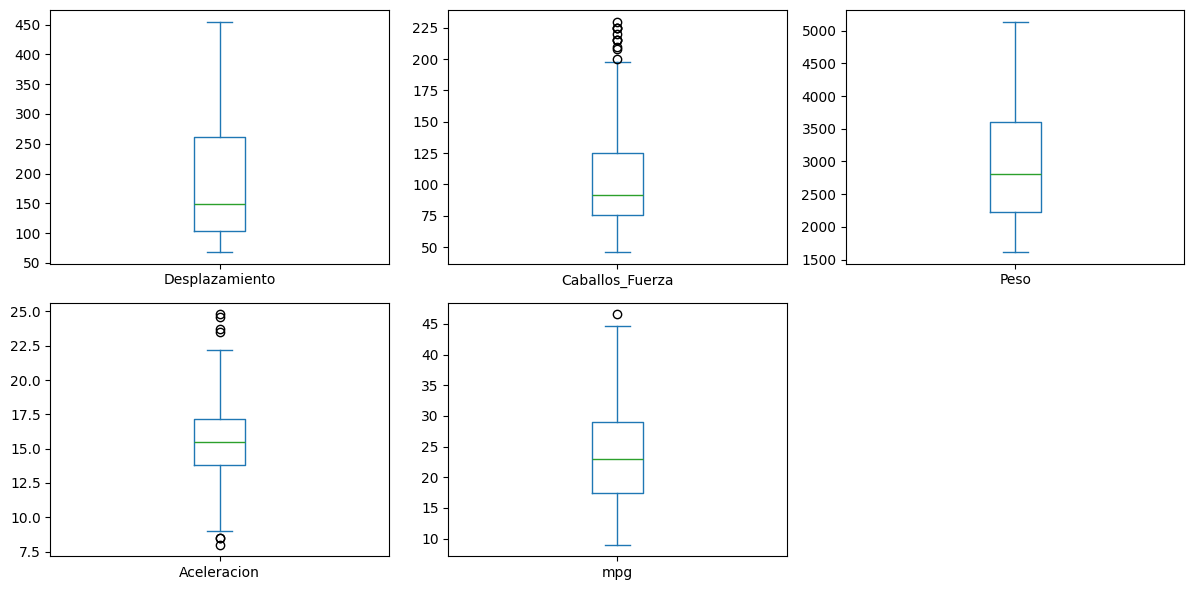

In [43]:
# Boxplot para ver outliers en todas las variables numéricas
df[['Desplazamiento','Caballos_Fuerza','Peso','Aceleracion','mpg']].plot(kind='box', subplots=True, layout=(2,3), figsize=(12,6))
plt.tight_layout()
plt.show()

### Análisis de correlaciones

In [19]:
# Correlación entre variables númericas
df.corr()

,Cilindros,Desplazamiento,Caballos_Fuerza,Peso,Aceleracion,modeloAnio,Origen,mpg
Cilindros,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932,-0.777618
Desplazamiento,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535,-0.805127
Caballos_Fuerza,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171,-0.778427
Peso,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005,-0.832244
Aceleracion,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746,0.423329
modeloAnio,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528,0.580541
Origen,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000,0.565209
mpg,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209,1.000000


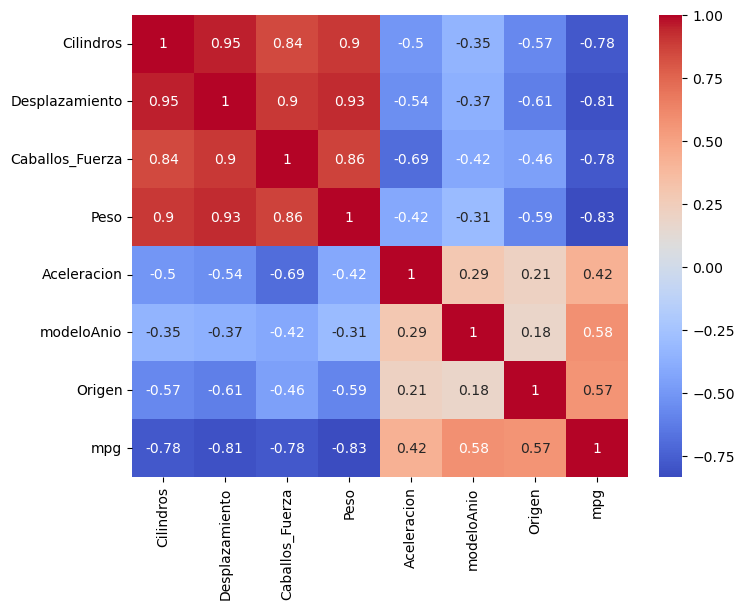

In [20]:
# Heatmap con coeficiente de pearson entre variables númericas
plt.figure(figsize=(8, 6)) 
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.show()

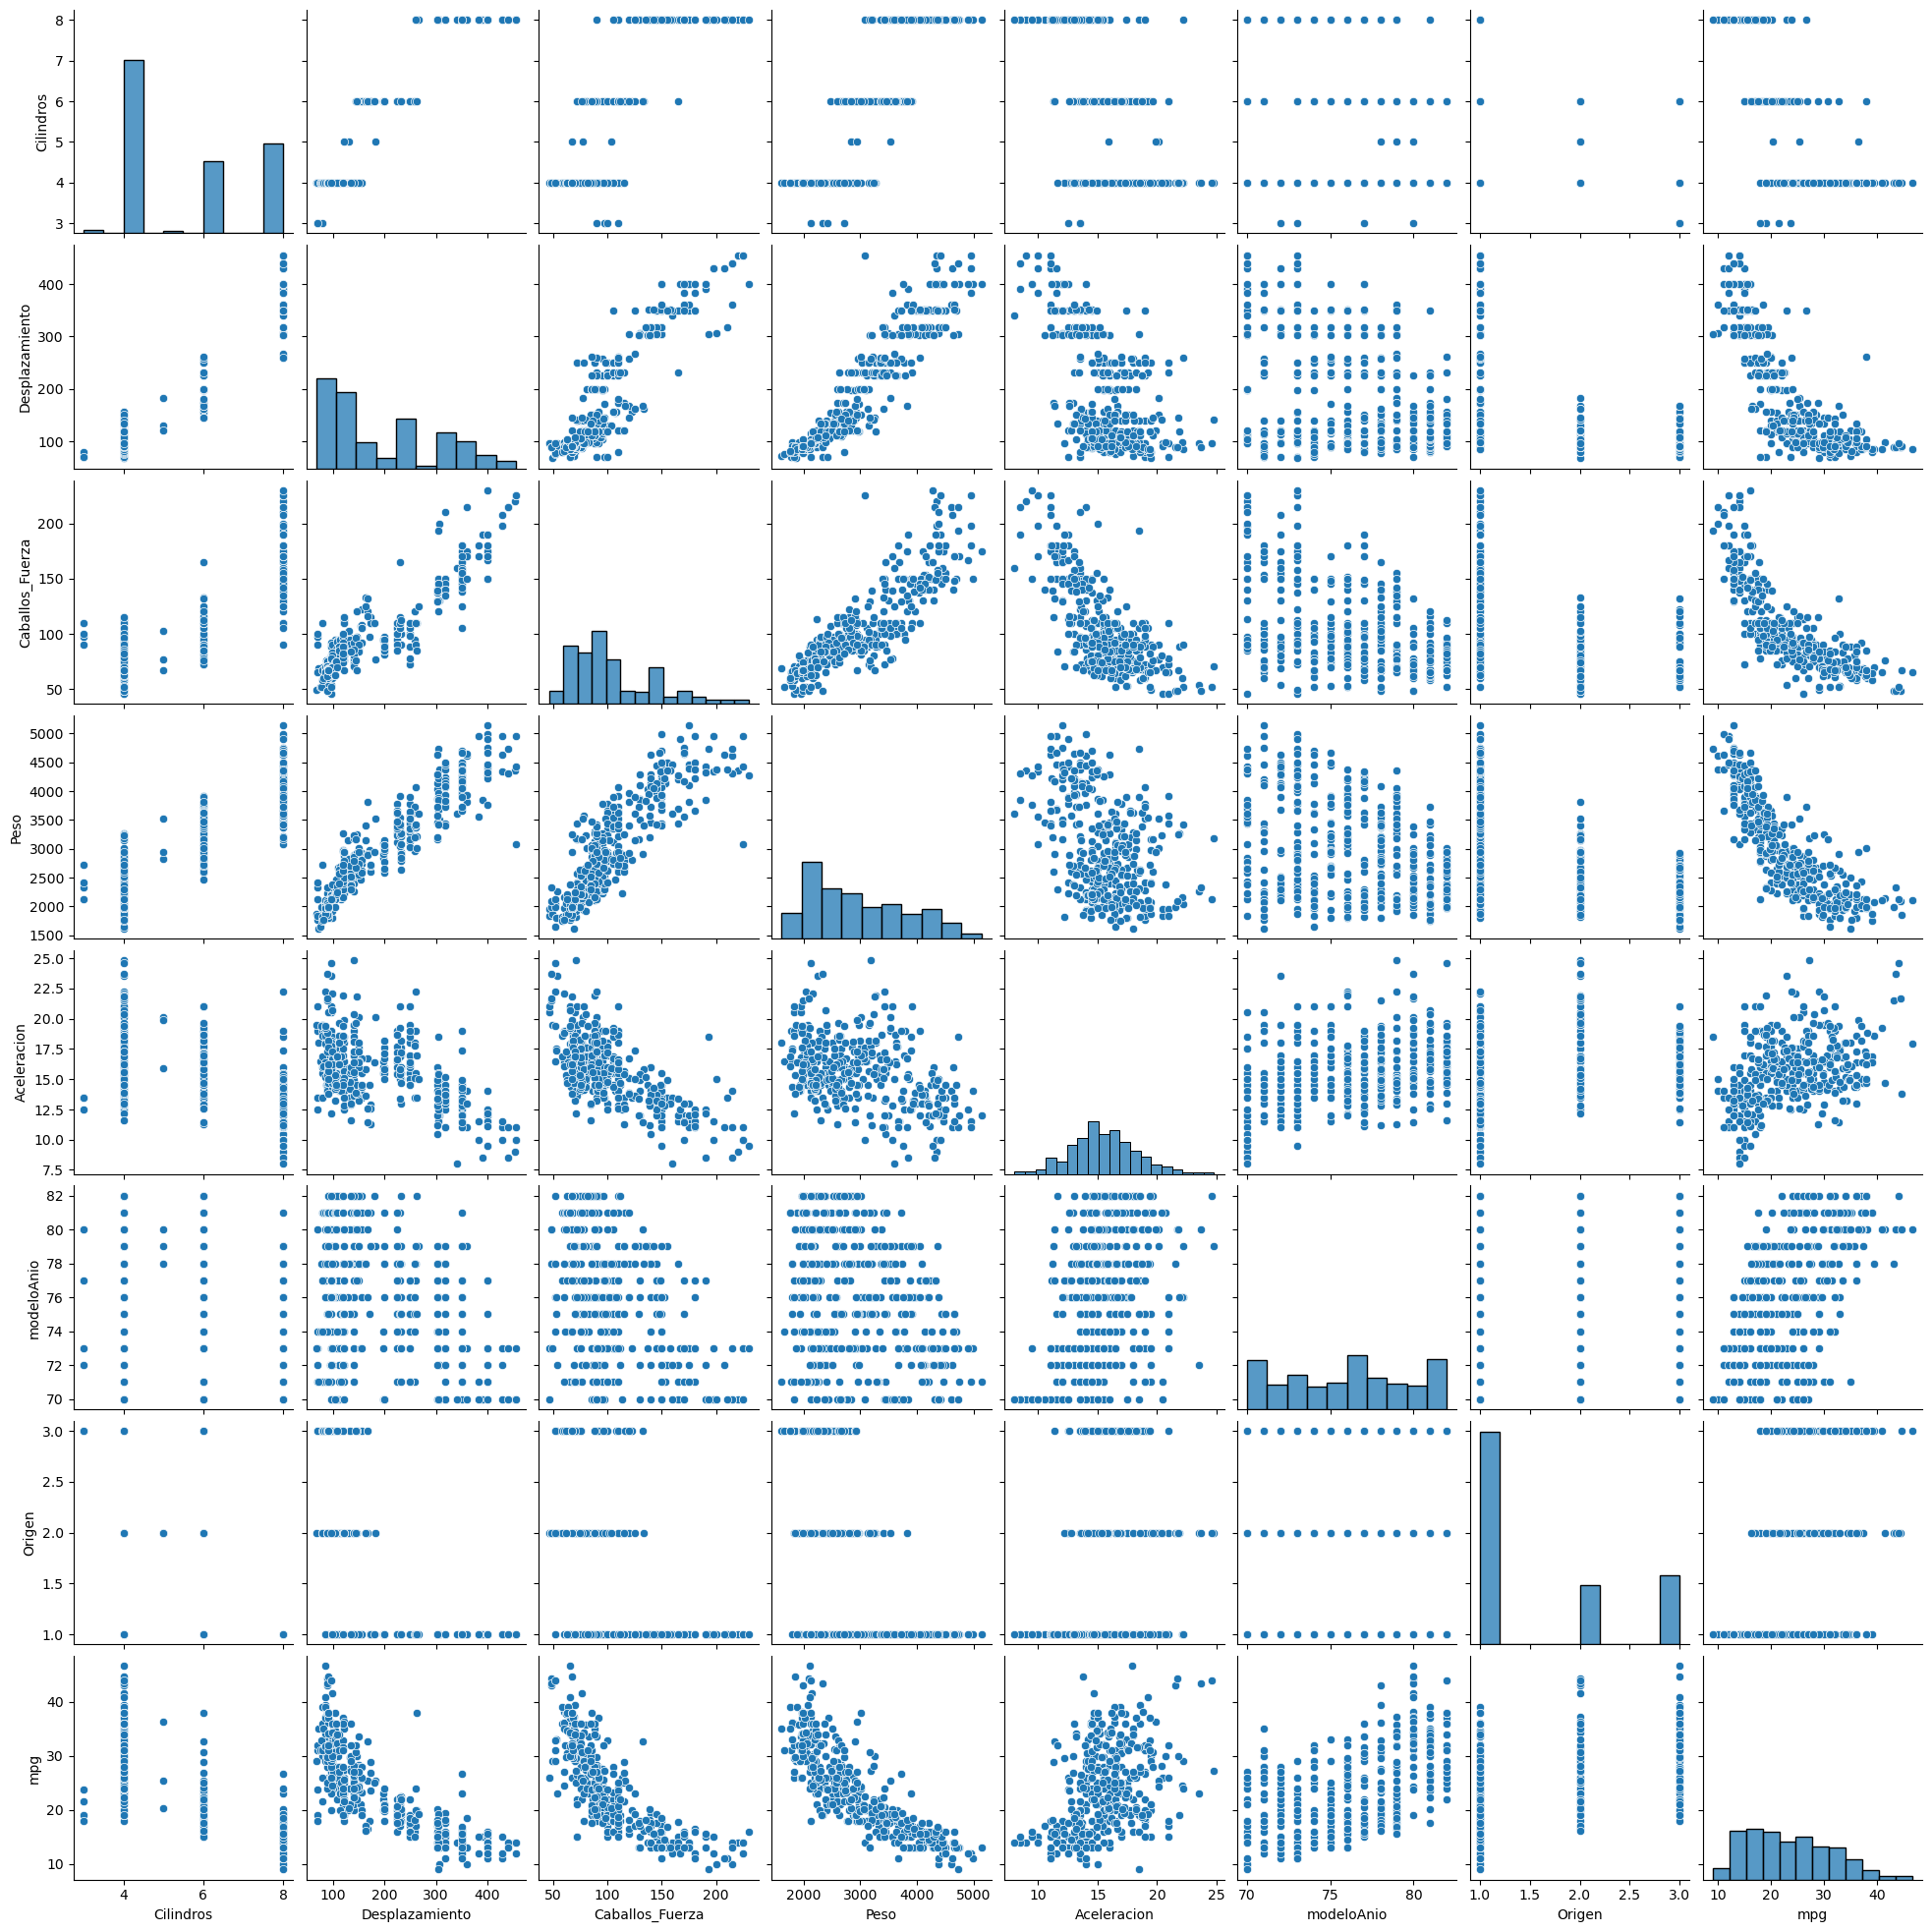

In [21]:
# Gráfico con visualizaciones de dispersión entre variable númericas
sns.pairplot(df)
plt.show()

### Modelo de Regresión Multivariado

In [44]:
lm = smf.ols(formula='Q("mpg") ~ Q("Peso") + Q("modeloAnio") + Q("Origen")',data=df).fit()

In [45]:
lm.params

Intercept         -18.045850
Q("Peso")          -0.005994
Q("modeloAnio")     0.757126
Q("Origen")         1.150391
dtype: float64

In [46]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Q("mpg")   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     579.2
Date:                Wed, 09 Jul 2025   Prob (F-statistic):          7.26e-143
Time:                        19:09:11   Log-Likelihood:                -1027.8
No. Observations:                 392   AIC:                             2064.
Df Residuals:                     388   BIC:                             2080.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -18.0459      4.001     -4.510      0.000     -25.913     -10.179
Q("Peso")          -0.0060      0.000    -23.588      0.000      -0.006      -0.005
Q("modeloAnio")     0.7571      0.048     15.668      0.000       0.662       0.852
Q("Origen")         1.1504      0.259      4.439      0.000       0.641       1.660
==============================================================================
Omnibus:                       39.172   Durbin-Watson:                   1.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.003
Skew:                           0.577   Prob(JB):                     3.13e-17
Kurtosis:                       4.823   Cond. No.                     7.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cálculo de metricas de error

In [47]:
y_real = df["mpg"]
y_pred = lm.predict(df[["Peso","modeloAnio", "Origen"]])

mae = metrics.meanabs(y_real, y_pred)
mse = metrics.mse(y_real, y_pred)
rmse = metrics.rmse(y_real, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Medium Squared Error: {rmse:.2f}")

Mean Absolute Error: 2.49
Mean Squared Error: 11.09
Root Medium Squared Error: 3.33


### Cálculo del coeficiente 

In [48]:
print(f"R2: {lm.rsquared:.3f}")
print(f"R2 ajustado: {lm.rsquared_adj:.3f}")

R2: 0.817
R2 ajustado: 0.816


### Gráfico de dispersión entre valores reales y predicciones del modelo construido

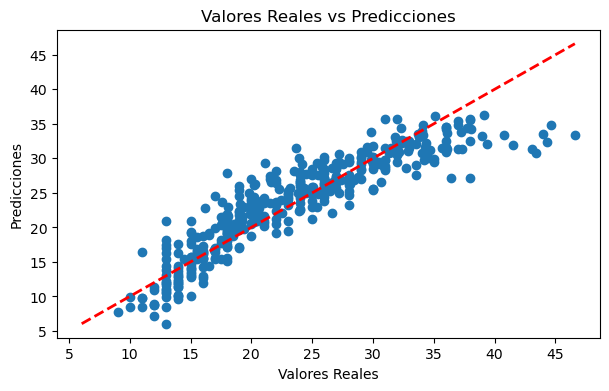

In [49]:
# Creación del gráfico de dispersión
plt.figure(figsize=(7,4))
plt.scatter(y_real,y_pred, label="Datos")

# Línea de regresión
lim_inf = min(y_real.min(), y_pred.min())
lim_sup = max(y_real.max(), y_pred.max())
plt.plot([lim_inf, lim_sup], [lim_inf, lim_sup],
         "r--", linewidth=2, label="Línea 1:1")

plt.title('Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

### Análisis de residuos

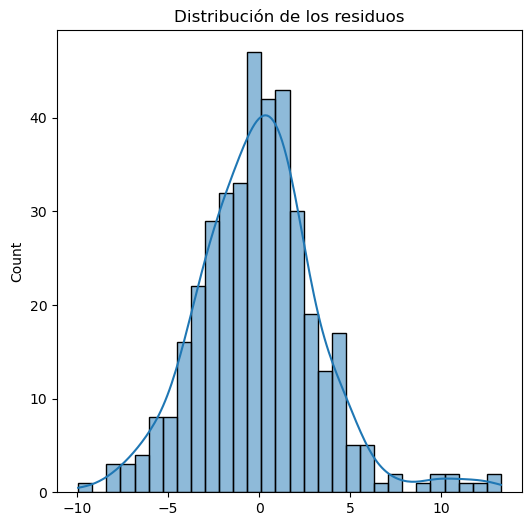

In [50]:
# Histograma de los residuos
residuos = y_real - y_pred

plt.figure(figsize=(6, 6)) 
sns.histplot(residuos, kde=True, bins=30)
plt.title("Distribución de los residuos")
plt.show()

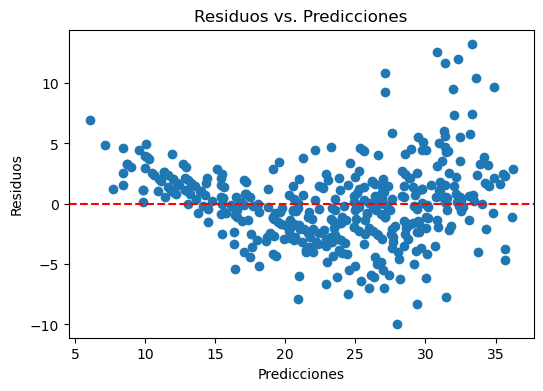

In [51]:
# Grafico de dispersión de Residuos vs. Predicciones
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos vs. Predicciones")
plt.show()

### Variable de mayor incidencia en el rendimiento del motor (mpg)

In [52]:
# Se crean modelos por cada una de las variables y se les cálcula el r cuadrado
variables = ["Peso","modeloAnio", "Origen"]

for var in variables:
    r2 = smf.ols(f"mpg ~ {var}", data=df).fit().rsquared
    print(f"{var}  →  {r2:.3f}")

Peso  →  0.693
modeloAnio  →  0.337
Origen  →  0.319


De acuerdo a los r cuadrado calculados para cada una de las variables integradas en el modelo de regresión multiple, el "peso" serían la variable con la mayor incidencia en el rendimiento del motor.

### ¿Es un mejor modelo que el simple? ¿Cómo se evidencia aquello?.

In [53]:
# Modelo Multivariado
print("#### MODELO MULTIVARIADO ####")
print(f"R2 ajustado: {lm.rsquared_adj:.3f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Medium Squared Error: {rmse:.2f}\n")

# Se crea modelo con la variable peso, que fue la que mostro mayor incidencia en mpg
lm_peso = smf.ols(f"mpg ~ Peso", data=df).fit()
y_real = df["mpg"]
y_pred = lm_peso.predict(df["Peso"])

print('##### MODELO SIMPLE ####')
print(f"R2 ajustado: {lm_peso.rsquared_adj:.3f}")
print(f"Mean Absolute Error: {metrics.meanabs(y_real, y_pred):.2f}")
print(f"Root Medium Squared Error: {metrics.rmse(y_real, y_pred):.2f}")

#### MODELO MULTIVARIADO ####
R2 ajustado: 0.816
Mean Absolute Error: 2.49
Root Medium Squared Error: 3.33

##### MODELO SIMPLE ####
R2 ajustado: 0.692
Mean Absolute Error: 3.28
Root Medium Squared Error: 4.32


En base a las metricas evaluadas (r cuadrado ajustado, MAE y RSME), se concluye que el modelo de regresión multivariado presenta un mejor ajuste que el modelo simple.

El modelo multivariado logra explicar aproximadamente el 81.6% de la variabilidad en el consumo de combustible (mpg), mientras que el modelo simple, que considera únicamente la variable "Peso", explica solo el 69.2%. Además, el multivariado presenta menores errores de predicción, con un MAE de 2.5 unidades y un RMSE de 3.32 unidades, frente a los 3.28 y 4.32 respectivamente del modelo simple.